# Testing General Powerlaws with Apparent Attractive Forces Between Spiral Tips
Tim Tyree<br>
12.6.2021

In [396]:
from lib.my_initialization import *
from lib import *
# from lib.measure.unwrap_and_smooth_cu import *
# from lib.rapids_func import *
# .routines.unwrap_and_smooth_trajectories_cu import *

import itertools
import dask_cudf
from lib.rapids_func import *
get_DT_cu

#magic    
%autocall 1
%load_ext autoreload
%autoreload 2

import cupy as cp, cudf, numba.cuda as cuda
import rmm
# Switch to RMM allocator
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [397]:
#TODO: make fig to show necessity of attraction coefficient
# % - visualize my brute force evidence that an attractive force is necessary
# %   - visualize (max/min) powerlaw exponents with/without a fixed inverse-powerlaw attractive force
# %   - xlabel='D',ylabel=r'$\kappa$'

In [398]:
#source data for annihilations
data_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_0.0_tavg2_14.00.csv'
data_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_0.0_tavg2_14.00.csv'
# df_annihilation=cudf.read_csv(data_dir_lr)
# df_annihilation.head()

In [399]:
data_folder='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results'
os.chdir(data_folder)
msr_dir_fk="msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv"
msr_dir_fk_final_only="msr_fk_boostrapped_tavg2_14.0_n_290_a_1.9_tmax_300_final_only.csv"


msr_dir_lr="msr_lr_boostrapped_tavg2_14.0_n_2083_a_2.6_tmax_300.csv"
msr_dir_lr_final_only="msr_lr_boostrapped_tavg2_14.0_n_62_a_3.2_tmax_300_final_only.csv"

In [400]:
df_lr=pd.read_csv(msr_dir_lr)
df_fk=pd.read_csv(msr_dir_fk)
# num_samples_max=df['counts'].max()
# df[df['counts'].values==num_samples_max]


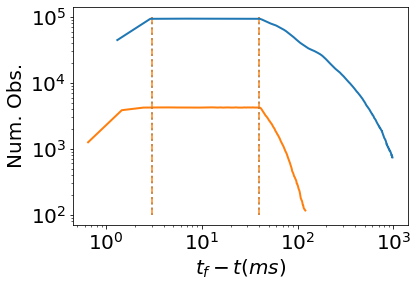

In [401]:
# #TODO(later): plot where the time bins are
tstart_fk=3
tend_fk=40
tstart_lr=3
tend_lr=40

ax=df_lr.plot(x='tdeath_avg',y='counts',lw=2,c='C1')
#plot vertical lines for each
yv=np.linspace(1e2,1e5)
ax.plot(tstart_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
ax.plot(tend_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
ax.plot(tstart_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)
ax.plot(tend_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)


df_fk.plot(x='tdeath_avg',y='counts',lw=2,c='C0',ax=ax)
format_plot(ax=ax,xlabel=r'$t_f-t (ms)$',ylabel='Num. Obs.')
ax.get_legend().remove()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [402]:
num_samples_max_fk=df_fk['counts'].max()
num_samples_max_lr=df_lr['counts'].max()
print(f"the max number of samples is N={num_samples_max_lr} (LR) and N={num_samples_max_fk} (FK)")

the max number of samples is N=4257 (LR) and N=94518 (FK)


In [403]:
tstart=2
tend=40
# ax=df_lr.plot(x='tdeath_avg',y='counts',lw=2,c='C1')
# df_fk.plot(x='tdeath_avg',y='counts',lw=2,c='C0',ax=ax)
# format_plot(ax=ax,xlabel=r'$t_f-t (ms)$',ylabel='Num. Obs.')
# ax.get_legend().remove()
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.show()

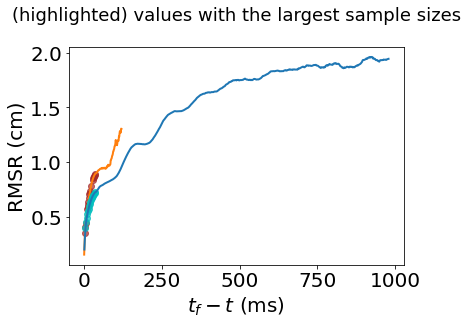

In [444]:

df=df_lr
tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_lr
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
# print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
# print(f"considering all time bins with at least N={frac} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=np.sqrt(df.loc[boo,'MSR']).values
#plot
plt.plot(t_values,R_values,'o',c='brown',lw=1,alpha=0.7)
plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C1')


df=df_fk.copy()
# tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_fk
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
# print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
# print(f"considering all time bins with at least N={frac} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=np.sqrt(df.loc[boo,'MSR']).values
#plot
plt.plot(t_values,R_values,'co',lw=1,alpha=0.7)
plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C0')


# #plot vertical lines for each
# yv=np.linspace(0,2)
# ax.plot(tstart_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tend_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tstart_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)
# ax.plot(tend_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)


format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'RMSR (cm)')
plt.title(f'(highlighted) values with the largest sample sizes\n',fontsize=18)
plt.show()
#DONE: extract MSR versus tdeath_avg for both models
#TODO: visualize MSR versus tdeath_avg for LR model too
#TODO: plot on log-log plot
#TODO: compute derivative by finite difference
#TODO: visualize (-)dRdt versus R. try the following:
# - linlin
# - loglog
# - loglin
# - linlog
#TODO: google 'how to change typing to insert linux keyboard'

t_start=3.475242386232975,t_end=40.09452477094064,num_tbins=19
considering all time bins with at least N=4236 samples
t_start=4.87544877720002,t_end=38.52789862900964,num_tbins=18
considering all time bins with at least N=94045 samples


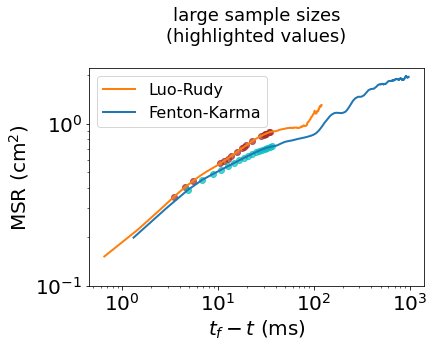

In [363]:

df=df_lr
tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_lr
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=np.sqrt(df.loc[boo,'MSR']).values
#plot
plt.plot(t_values,R_values,'o',c='brown',lw=1,alpha=0.7)
plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C1',label='Luo-Rudy')


df=df_fk.copy()
# tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_fk
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=np.sqrt(df.loc[boo,'MSR']).values
#plot
plt.plot(t_values,R_values,'co',lw=1,alpha=0.7)
plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C0',label='Fenton-Karma')


# #plot vertical lines for each
# yv=np.linspace(0,2)
# ax.plot(tstart_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tend_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tstart_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)
# ax.plot(tend_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)

plt.legend(fontsize=16)
plt.xscale('log')
plt.yscale('log')
# plt.xlim([.1,2])
plt.ylim([.1,2.2])
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.title(f'large sample sizes\n(highlighted values)\n',fontsize=18)
# plt.title(f'(highlighted) values with the large sample sizes\n',fontsize=18)
plt.show()
#DONE: extract MSR versus tdeath_avg for both models
#TODO: visualize MSR versus tdeath_avg for LR model too
#TODO: plot on log-log plot
#TODO: compute derivative by finite difference
#TODO: visualize (-)dRdt versus R. try the following:
# - linlin
# - loglog
# - loglin
# - linlog 
#TODO: google 'how to change typing to insert linux keyboard'

In [359]:
#compute drdt for both dataframes
df_lr['R']=np.sqrt(df_lr['MSR'])
df_fk['R']=np.sqrt(df_fk['MSR'])
df_lr.sort_values(by='tdeath_avg',inplace=True)
df_lr['dRdt']=df_lr['R'].diff()/df_lr['tdeath_avg'].diff()*1e3
df_fk.sort_values(by='tdeath_avg',inplace=True)
df_fk['dRdt']=df_fk['R'].diff()/df_fk['tdeath_avg'].diff()*1e3

t_start=3.475242386232975,t_end=40.09452477094064,num_tbins=19
considering all time bins with at least N=4236 samples
t_start=4.87544877720002,t_end=38.52789862900964,num_tbins=18
considering all time bins with at least N=94045 samples


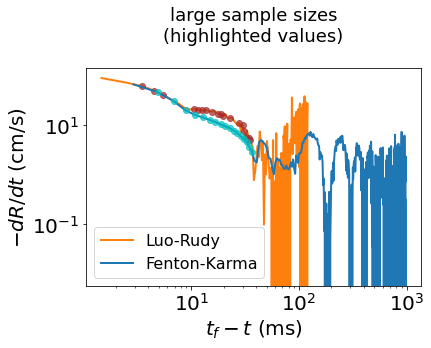

In [364]:
tol_max_sample_fraction=.005
df=df_lr
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_lr
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=df.loc[boo,'R'].values
dRdt_values=df.loc[boo,'dRdt'].values
#plot
plt.plot(df['tdeath_avg'].values,df['dRdt'].values,lw=2,c='C1',label='Luo-Rudy')
plt.plot(t_values,dRdt_values,'o',c='brown',lw=1,alpha=0.7)

df=df_fk.copy()
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_fk
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=df.loc[boo,'R'].values
dRdt_values=df.loc[boo,'dRdt'].values
#plot
plt.plot(df['tdeath_avg'].values,df['dRdt'].values,lw=2,c='C0',label='Fenton-Karma')
plt.plot(t_values,dRdt_values,'o',c='c',lw=1,alpha=0.7)


# #plot vertical lines for each
# yv=np.linspace(0,2)
# ax.plot(tstart_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tend_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tstart_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)
# ax.plot(tend_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)

plt.legend(fontsize=16)
plt.xscale('log')
plt.yscale('log')
# plt.xlim([.1,2])
# plt.ylim([.1,2.2])
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'$-dR/dt$ (cm/s)')
plt.title(f'large sample sizes\n(highlighted values)\n',fontsize=18)
# plt.title(f'(highlighted) values with the large sample sizes\n',fontsize=18)
plt.show()
#DONE: extract MSR versus tdeath_avg for both models
#TODO: visualize MSR versus tdeath_avg for LR model too
#TODO: plot on log-log plot
#TODO: compute derivative by finite difference
#TODO: visualize (-)dRdt versus R. try the following:
# - linlin
# - loglog
# - loglin
# - linlog 
#TODO: google 'how to change typing to insert linux keyboard'

t_start=3.475242386232975,t_end=40.09452477094064,num_tbins=19
considering all time bins with at least N=4236 samples
t_start=4.87544877720002,t_end=38.52789862900964,num_tbins=18
considering all time bins with at least N=94045 samples


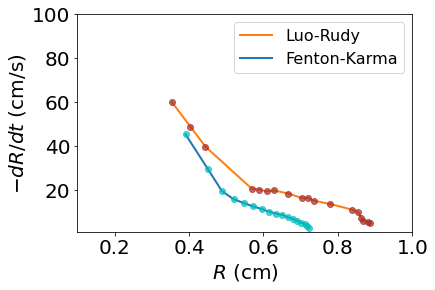

In [379]:
tol_max_sample_fraction=.005
df=df_lr
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_lr
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=df.loc[boo,'R'].values
dRdt_values=df.loc[boo,'dRdt'].values
#plot
plt.plot(df[boo]['R'].values,df[boo]['dRdt'].values,lw=2,c='C1',label='Luo-Rudy')
plt.plot(R_values,dRdt_values,'o',c='brown',lw=1,alpha=0.7)

df=df_fk.copy()
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_fk
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=df.loc[boo,'R'].values
dRdt_values=df.loc[boo,'dRdt'].values
#plot
plt.plot(df[boo]['R'].values,df[boo]['dRdt'].values,lw=2,c='C0',label='Fenton-Karma')
plt.plot(R_values,dRdt_values,'o',c='c',lw=1,alpha=0.7)


# #plot vertical lines for each
# yv=np.linspace(0,2)
# ax.plot(tstart_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tend_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tstart_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)
# ax.plot(tend_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)

plt.legend(fontsize=16)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([1e-1,1e0])
plt.ylim([1,100])
format_plot(ax=plt.gca(),xlabel=r'$R$ (cm)',ylabel=r'$-dR/dt$ (cm/s)')
# plt.title(f'large sample sizes\n(highlighted values)\n',fontsize=18)
# plt.title(f'(highlighted) values with the large sample sizes\n',fontsize=18)
plt.show()
#DONE: extract MSR versus tdeath_avg for both models
#TODO: visualize MSR versus tdeath_avg for LR model too
#TODO: plot on log-log plot
#TODO: compute derivative by finite difference
#TODO: visualize (-)dRdt versus R. try the following:
# - linlin
# - loglog
# - loglin
# - linlog 
#TODO: google 'how to change typing to insert linux keyboard'

t_start=3.475242386232975,t_end=40.09452477094064,num_tbins=19
considering all time bins with at least N=4236 samples
t_start=4.87544877720002,t_end=38.52789862900964,num_tbins=18
considering all time bins with at least N=94045 samples


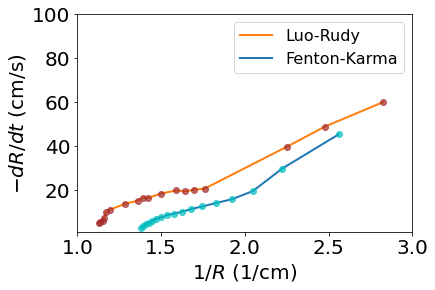

In [380]:
tol_max_sample_fraction=.005
df=df_lr
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_lr
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=df.loc[boo,'R'].values
dRdt_values=df.loc[boo,'dRdt'].values
#plot
plt.plot(1/df[boo]['R'].values,df[boo]['dRdt'].values,lw=2,c='C1',label='Luo-Rudy')
plt.plot(1/R_values,dRdt_values,'o',c='brown',lw=1,alpha=0.7)

df=df_fk.copy()
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_fk
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=df.loc[boo,'R'].values
dRdt_values=df.loc[boo,'dRdt'].values
#plot
plt.plot(1/df[boo]['R'].values,df[boo]['dRdt'].values,lw=2,c='C0',label='Fenton-Karma')
plt.plot(1/R_values,dRdt_values,'o',c='c',lw=1,alpha=0.7)


# #plot vertical lines for each
# yv=np.linspace(0,2)
# ax.plot(tstart_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tend_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tstart_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)
# ax.plot(tend_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)

plt.legend(fontsize=16)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([1e0,3])
plt.ylim([1,100])
format_plot(ax=plt.gca(),xlabel=r'$1/R$ (1/cm)',ylabel=r'$-dR/dt$ (cm/s)')
# plt.title(f'large sample sizes\n(highlighted values)\n',fontsize=18)
# plt.title(f'(highlighted) values with the large sample sizes\n',fontsize=18)
plt.show()
#DONE: extract MSR versus tdeath_avg for both models
#TODO: visualize MSR versus tdeath_avg for LR model too
#TODO: plot on log-log plot
#TODO: compute derivative by finite difference
#TODO: visualize (-)dRdt versus R. try the following:
# - linlin
# - loglog
# - loglin
# - linlog 
#TODO: google 'how to change typing to insert linux keyboard'

t_start=3.475242386232975,t_end=40.09452477094064,num_tbins=19
considering all time bins with at least N=4236 samples
t_start=4.87544877720002,t_end=38.52789862900964,num_tbins=18
considering all time bins with at least N=94045 samples


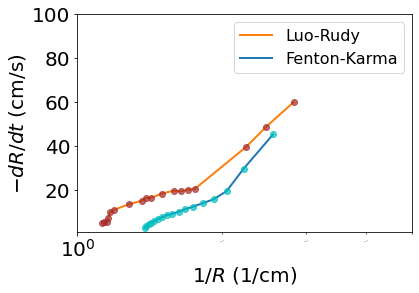

In [382]:
tol_max_sample_fraction=.005
df=df_lr
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_lr
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=df.loc[boo,'R'].values
dRdt_values=df.loc[boo,'dRdt'].values
#plot
plt.plot(1/df[boo]['R'].values,df[boo]['dRdt'].values,lw=2,c='C1',label='Luo-Rudy')
plt.plot(1/R_values,dRdt_values,'o',c='brown',lw=1,alpha=0.7)

df=df_fk.copy()
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_fk
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=df.loc[boo,'R'].values
dRdt_values=df.loc[boo,'dRdt'].values
#plot
plt.plot(1/df[boo]['R'].values,df[boo]['dRdt'].values,lw=2,c='C0',label='Fenton-Karma')
plt.plot(1/R_values,dRdt_values,'o',c='c',lw=1,alpha=0.7)

plt.legend(fontsize=16)
plt.xscale('log')
# plt.yscale('log')
plt.xlim([1e0,5])
plt.ylim([1,100])
format_plot(ax=plt.gca(),xlabel=r'$1/R$ (1/cm)',ylabel=r'$-dR/dt$ (cm/s)')
plt.show()
#TODO: google 'how to change typing to insert linux keyboard'

t_start=3.475242386232975,t_end=40.09452477094064,num_tbins=19
considering all time bins with at least N=4236 samples
t_start=4.87544877720002,t_end=38.52789862900964,num_tbins=18
considering all time bins with at least N=94045 samples


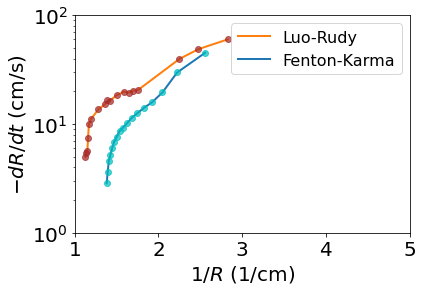

In [383]:
tol_max_sample_fraction=.005
df=df_lr
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_lr
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=df.loc[boo,'R'].values
dRdt_values=df.loc[boo,'dRdt'].values
#plot
plt.plot(1/df[boo]['R'].values,df[boo]['dRdt'].values,lw=2,c='C1',label='Luo-Rudy')
plt.plot(1/R_values,dRdt_values,'o',c='brown',lw=1,alpha=0.7)

df=df_fk.copy()
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_fk
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=df.loc[boo,'R'].values
dRdt_values=df.loc[boo,'dRdt'].values
#plot
plt.plot(1/df[boo]['R'].values,df[boo]['dRdt'].values,lw=2,c='C0',label='Fenton-Karma')
plt.plot(1/R_values,dRdt_values,'o',c='c',lw=1,alpha=0.7)

plt.legend(fontsize=16)
# plt.xscale('log')
plt.yscale('log')
plt.xlim([1e0,5])
plt.ylim([1,100])
format_plot(ax=plt.gca(),xlabel=r'$1/R$ (1/cm)',ylabel=r'$-dR/dt$ (cm/s)')
plt.show()
#TODO: google 'how to change typing to insert linux keyboard'

t_start=3.475242386232975,t_end=40.09452477094064,num_tbins=19
considering all time bins with at least N=4236 samples
t_start=4.87544877720002,t_end=38.52789862900964,num_tbins=18
considering all time bins with at least N=94045 samples


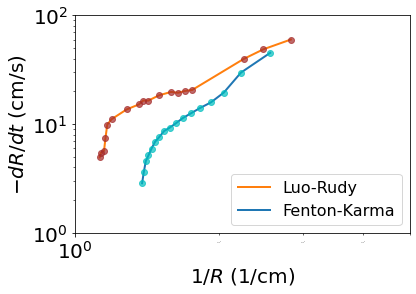

In [384]:
tol_max_sample_fraction=.005
df=df_lr
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_lr
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=df.loc[boo,'R'].values
dRdt_values=df.loc[boo,'dRdt'].values
#plot
plt.plot(1/df[boo]['R'].values,df[boo]['dRdt'].values,lw=2,c='C1',label='Luo-Rudy')
plt.plot(1/R_values,dRdt_values,'o',c='brown',lw=1,alpha=0.7)

df=df_fk.copy()
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_fk
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=df.loc[boo,'R'].values
dRdt_values=df.loc[boo,'dRdt'].values
#plot
plt.plot(1/df[boo]['R'].values,df[boo]['dRdt'].values,lw=2,c='C0',label='Fenton-Karma')
plt.plot(1/R_values,dRdt_values,'o',c='c',lw=1,alpha=0.7)

plt.legend(fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e0,5])
plt.ylim([1,100])
format_plot(ax=plt.gca(),xlabel=r'$1/R$ (1/cm)',ylabel=r'$-dR/dt$ (cm/s)')
plt.show()
#TODO: google 'how to change typing to insert linux keyboard'

# perform moving average on both traces

In [432]:
def resample_linearly(df,dt=0.1,t_col='tdeath_avg',pos_col='MSR'):
    '''compute the linearly interpolated time series at a regular interval of dt
    Example Usage:
    t_values_interpolated,x_values_interpolated=resample_linearly(df,dt=0.1,t_col='tdeath_avg',pos_col='MSR')
    '''
    sd_values=df[pos_col].values
    tau_values=df[t_col].values
    t_values_interpolated=np.arange(tau_values.min(),tau_values.max(),dt)
    x_values_interpolated=np.interp(x=t_values_interpolated, xp=tau_values, fp=sd_values, left=None, right=None, period=None)
`return t_values_interpolated, x_values_interpolated

In [525]:
#interpolate and smooth the MSR versus time until death
# tavg=100#ms
tavg=90#ms
dt_resample=0.1#ms

df=df_lr
#extract MSR versus tdeath_avg in this range
t_values=df['tdeath_avg'].values
MSR_values=df['MSR'].values

navg=int(tavg/dt_resample)
#resample at fixed rate of 0.1 ms
t_values_interpolated,x_values_interpolated=resample_linearly(df,dt=dt_resample,t_col='tdeath_avg',pos_col='MSR')
#perform moving average at 90ms moving average
t_values_interpolated_ma=moving_average(t_values_interpolated,navg)
x_values_interpolated_ma=moving_average(x_values_interpolated,navg)

t_LR=t_values_interpolated_ma.copy()
MSR_LR=x_values_interpolated_ma.copy()

df=df_fk
#extract MSR versus tdeath_avg in this range
t_values=df['tdeath_avg'].values
MSR_values=df['MSR'].values

navg=int(tavg/dt_resample)
#resample at fixed rate of 0.1 ms
t_values_interpolated,x_values_interpolated=resample_linearly(df,dt=dt_resample,t_col='tdeath_avg',pos_col='MSR')
#perform moving average at 90ms moving average
t_values_interpolated_ma=moving_average(t_values_interpolated,navg)
x_values_interpolated_ma=moving_average(x_values_interpolated,navg)

t_FK=t_values_interpolated_ma.copy()
MSR_FK=x_values_interpolated_ma.copy()

In [526]:
# plt.plot(t_values,MSR_values)

# format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.title(f'moving average window duration: {tavg:.0f} ms\n',fontsize=18)
# # plt.title(f'(highlighted) values with the large sample sizes\n',fontsize=18)
# plt.show()

t_start=4.87544877720002,t_end=38.52789862900964,num_tbins=18
considering all time bins with at least N=94045 samples
t_start=3.475242386232975,t_end=40.09452477094064,num_tbins=19
considering all time bins with at least N=4236 samples


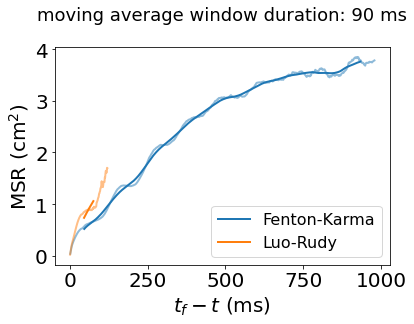

In [527]:
df=df_fk.copy()
tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_fk
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
print(f"considering all time bins with at least N={frac:.0f} samples")

x=t_FK;y=MSR_FK
boo=(x>t_start)&(x<t_end)
#plot
plt.plot(x[boo],y[boo],'o',c='c',lw=1,alpha=0.7)
plt.plot(df['tdeath_avg'].values,df['MSR'].values,lw=2,c='C0',alpha=0.5)
plt.plot(t_FK,MSR_FK,lw=2,c='C0',label='Fenton-Karma')


df=df_lr.copy()
tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_lr
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
print(f"considering all time bins with at least N={frac:.0f} samples")

x=t_LR;y=MSR_LR
boo=(x>t_start)&(x<t_end)
#plot
plt.plot(x[boo],y[boo],'o',c='brown',lw=1,alpha=0.7)
plt.plot(df['tdeath_avg'].values,df['MSR'].values,lw=2,c='C1',alpha=0.5)
plt.plot(t_LR,MSR_LR,lw=2,c='C1',label='Luo-Rudy')

# df=df_fk.copy()
# # tol_max_sample_fraction=.005
# #find start/end times of max samples
# frac=(1-tol_max_sample_fraction)*num_samples_max_fk
# boo=df['counts'].values>=frac
# t_start=df[boo]['tdeath_avg'].min()
# t_end=df[boo]['tdeath_avg'].max()
# print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size}")
# boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
# print(f"considering all time bins with at least N={frac:.0f} samples")
# #extract MSR versus tdeath_avg in this range
# t_values=df.loc[boo,'tdeath_avg'].values
# R_values=np.sqrt(df.loc[boo,'MSR']).values
# #plot
# plt.plot(t_values,R_values**2,'co',lw=1,alpha=0.7)
# plt.plot(df['tdeath_avg'].values,df['MSR'].values,lw=2,c='C0',label='Fenton-Karma')


# #plot vertical lines for each
# yv=np.linspace(0,2)
# ax.plot(tstart_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tend_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tstart_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)
# ax.plot(tend_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)

plt.legend(fontsize=16)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([.1,2])
# plt.ylim([.1,2.2])
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.title(f'moving average window duration: {tavg:.0f} ms\n',fontsize=18)
# plt.title(f'large sample sizes\n(highlighted values)\n',fontsize=18)
# plt.title(f'(highlighted) values with the large sample sizes\n',fontsize=18)
plt.show()

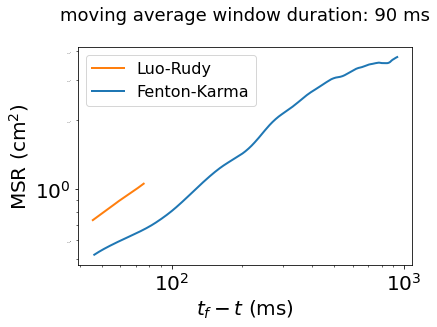

In [528]:
plt.plot(t_LR,MSR_LR,lw=2,c='C1',label='Luo-Rudy')
plt.plot(t_FK,MSR_FK,lw=2,c='C0',label='Fenton-Karma')

plt.legend(fontsize=16)
plt.xscale('log')
plt.yscale('log')
# plt.xlim([.1,2])
# plt.ylim([.1,2.2])
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.title(f'moving average window duration: {tavg:.0f} ms\n',fontsize=18)
# plt.title(f'large sample sizes\n(highlighted values)\n',fontsize=18)
# plt.title(f'(highlighted) values with the large sample sizes\n',fontsize=18)
plt.show()

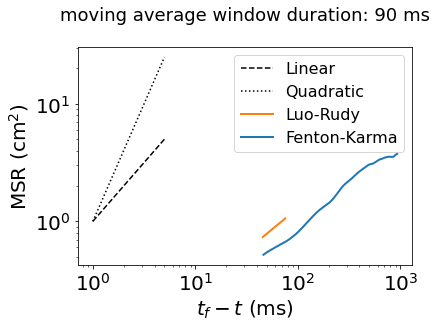

In [529]:
x=np.linspace(1,5,100)
x0=0.
y0=0.

plt.plot(x+x0,x+y0,'k--',label='Linear')
plt.plot(x+x0,x**2+y0,'k:',label='Quadratic')

plt.plot(t_LR,MSR_LR,lw=2,c='C1',label='Luo-Rudy')
plt.plot(t_FK,MSR_FK,lw=2,c='C0',label='Fenton-Karma')

plt.legend(fontsize=16)
plt.xscale('log')
plt.yscale('log')
# plt.xlim([.1,2])
# plt.ylim([.1,2.2])
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.title(f'moving average window duration: {tavg:.0f} ms\n',fontsize=18)
# plt.title(f'large sample sizes\n(highlighted values)\n',fontsize=18)
# plt.title(f'(highlighted) values with the large sample sizes\n',fontsize=18)
plt.show()

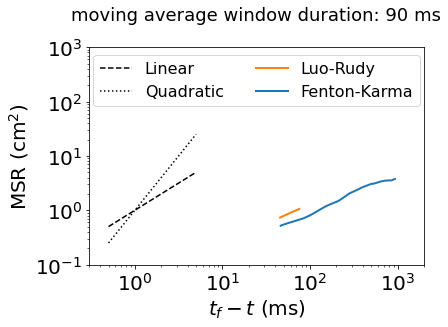

In [548]:
# x=np.linspace(1,5,100)
x=np.linspace(0.5,5,100)
x0=0.
y0=0.
# fig,ax=plt.subplots()
plt.plot(x+x0,x+y0,'k--',label='Linear')
plt.plot(x+x0,x**2+y0,'k:',label='Quadratic')

plt.plot(t_LR,MSR_LR,lw=2,c='C1',label='Luo-Rudy')
plt.plot(t_FK,MSR_FK,lw=2,c='C0',label='Fenton-Karma')

plt.legend(fontsize=16,ncol=2,loc='upper center')
plt.xscale('log')
plt.yscale('log')
plt.xlim([.3,2e3])
plt.ylim([0.1,1e3])
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.title(f'moving average window duration: {tavg:.0f} ms\n',fontsize=18)
# plt.title(f'large sample sizes\n(highlighted values)\n',fontsize=18)
# plt.title(f'(highlighted) values with the large sample sizes\n',fontsize=18)
plt.show()

In [567]:
tmax=300 #s
xv=np.linspace(30,1050,100)

#FK
print(f"for the Fenton-Karma model:")
#print power law
boo_FK=t_FK<tmax
x=t_FK[boo_FK]
y=MSR_FK[boo_FK]
# x-=np.min(x)+1e-3
# y-=np.min(y)+1e-3
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
dict_fit=dict(B=B,Delta_B=Delta_B,m=m,Delta_m=Delta_m,Rsq=Rsq)
print_dict(dict_fit)
dict_fit_FK=dict_fit
#compute yhat
yhat=(B*xv)**m
yhat_FK=yhat.copy()

#LR
print(f"\nfor the Luo-Rudy model:")
#print power law
boo_LR=t_LR<tmax
x=t_LR[boo_LR]
y=MSR_LR[boo_LR]
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
dict_fit=dict(B=B,Delta_B=Delta_B,m=m,Delta_m=Delta_m,Rsq=Rsq)
print_dict(dict_fit)
dict_fit_LR=dict_fit
#compute yhat
yhat=(B*xv)**m
yhat_LR=yhat.copy()

for the Fenton-Karma model:
B=0.008560459428361885
Delta_B=3.0410752368805252e-05
m=0.7972122403329093
Delta_m=0.002946520977576909
Rsq=0.991062637595276

for the Luo-Rudy model:
B=0.014295359715503162
Delta_B=2.514493816509508e-05
m=0.7161112648789253
Delta_m=0.0012718900811051373
Rsq=0.9997553551880178


In [592]:
tmax=300 #s
xv=np.linspace(30,1050,100)

print("powerlaw fits")
#FK
print(f"for the Fenton-Karma model:")
#print power law
boo_FK=t_FK<tmax
x=t_FK[boo_FK]
y=MSR_FK[boo_FK]
# x-=np.min(x)+1e-3
# y-=np.min(y)+1e-3
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
dict_fit=dict(B=B,Delta_B=Delta_B,m=m,Delta_m=Delta_m,Rsq=Rsq)
print_dict(dict_fit)
dict_fit_FK=dict_fit
#compute yhat
yhat=(B*xv)**m
yhat_FK=yhat.copy()
#print RMSE
yhat_=(B*x)**m
RMSE=np.sqrt(np.mean((y-yhat_)**2))
print(f"RMSE={RMSE:.6f}")

#LR
print(f"\nfor the Luo-Rudy model:")
#print power law
boo_LR=t_LR<tmax
x=t_LR[boo_LR]
y=MSR_LR[boo_LR]
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
dict_fit=dict(B=B,Delta_B=Delta_B,m=m,Delta_m=Delta_m,Rsq=Rsq)
print_dict(dict_fit)
dict_fit_LR=dict_fit
#compute yhat
yhat=(B*xv)**m
yhat_LR=yhat.copy()
#print RMSE
yhat_=(B*x)**m
RMSE=np.sqrt(np.mean((y-yhat_)**2))
print(f"RMSE={RMSE:.6f}")


powerlaw fits
for the Fenton-Karma model:
B=0.008560459428361885
Delta_B=3.0410752368805252e-05
m=0.7972122403329093
Delta_m=0.002946520977576909
Rsq=0.991062637595276
RMSE=0.065960

for the Luo-Rudy model:
B=0.014295359715503162
Delta_B=2.514493816509508e-05
m=0.7161112648789253
Delta_m=0.0012718900811051373
Rsq=0.9997553551880178
RMSE=0.001944


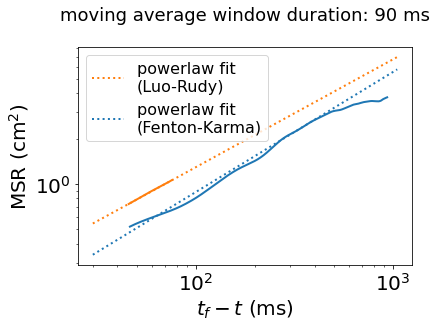

In [593]:
#plot power law fit
plt.plot(t_LR,MSR_LR,lw=2,c='C1')#,label='Luo-Rudy')
plt.plot(t_FK,MSR_FK,lw=2,c='C0')#,label='Fenton-Karma')
plt.plot(xv,yhat_LR,":",lw=2,c='C1',label='powerlaw fit\n(Luo-Rudy)')
plt.plot(xv,yhat_FK,":",lw=2,c='C0',label='powerlaw fit\n(Fenton-Karma)')
#format
plt.legend(fontsize=16)
plt.xscale('log')
plt.yscale('log')
# plt.xlim([.1,2])
# plt.ylim([.1,2.2])
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.title(f'moving average window duration: {tavg:.0f} ms\n',fontsize=18)
plt.show()

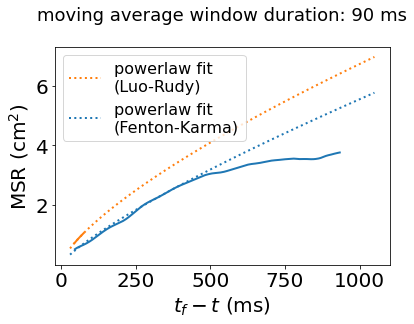

In [595]:
#plot power law fit
plt.plot(t_LR,MSR_LR,lw=2,c='C1')#,label='Luo-Rudy')
plt.plot(t_FK,MSR_FK,lw=2,c='C0')#,label='Fenton-Karma')
plt.plot(xv,yhat_LR,":",lw=2,c='C1',label='powerlaw fit\n(Luo-Rudy)')
plt.plot(xv,yhat_FK,":",lw=2,c='C0',label='powerlaw fit\n(Fenton-Karma)')
#format
plt.legend(fontsize=16)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([.1,2])
# plt.ylim([.1,2.2])
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.title(f'moving average window duration: {tavg:.0f} ms\n',fontsize=18)
plt.show()

{'m': 0.010687275885076232,
 'Delta_m': 3.738065695922068e-05,
 'b': 0.25409238835775805,
 'Delta_b': 0.0022864491666492732,
 'Rsquared': 0.9990519047038209}

In [589]:
print("linear fits")
#FK
print(f"for the Fenton-Karma model:")
#print power law
boo_FK=t_FK<tmax
x=t_FK[boo_FK]
y=MSR_FK[boo_FK]
dict_fit=compute_95CI_ols(x,y)
print_dict(dict_fit)
dict_fit_FK=dict_fit
#compute yhat
yhat=xv*dict_fit['m']+dict_fit['b']
yhat_FK=yhat.copy()
#print RMSE
yhat_=x*dict_fit['m']+dict_fit['b']
RMSE=np.sqrt(np.mean((y-yhat_)**2))
print(f"RMSE={RMSE:.6f}")
print(f"a={dict_fit['m']/4e-3:.4f}+/-{dict_fit['Delta_m']/4e-3:.4f} cm^2/s")

#LR
print(f"\nfor the Luo-Rudy model:")
#print power law
boo_LR=t_LR<tmax
x=t_LR[boo_LR]
y=MSR_LR[boo_LR]
dict_fit=compute_95CI_ols(x,y)
print_dict(dict_fit)
dict_fit_FK=dict_fit
#compute yhat
yhat=xv*dict_fit['m']+dict_fit['b']
yhat_LR=yhat.copy()
#print RMSE
yhat_=x*dict_fit['m']+dict_fit['b']
RMSE=np.sqrt(np.mean((y-yhat_)**2))
print(f"RMSE={RMSE:.6f}")
print(f"a={dict_fit['m']/4e-3:.4f}+/-{dict_fit['Delta_m']/4e-3:.4f} cm^2/s")

linear fits
for the Fenton-Karma model:
m=0.006422723166729536
Delta_m=1.4698671286041725e-05
b=0.18409368793283765
Delta_b=0.0027630422545144
Rsquared=0.9965544710997846
RMSE=0.027669
a=1.6057+/-0.0037 cm^2/s

for the Luo-Rudy model:
m=0.010687275885076232
Delta_m=3.738065695922068e-05
b=0.25409238835775805
Delta_b=0.0022864491666492732
Rsquared=0.9990519047038209
RMSE=0.002851
a=2.6718+/-0.0093 cm^2/s


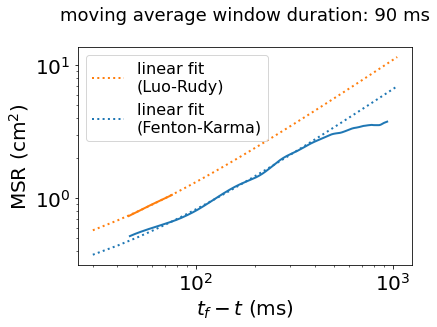

In [590]:
#plot linear law fit
plt.plot(t_LR,MSR_LR,lw=2,c='C1')#,label='Luo-Rudy')
plt.plot(t_FK,MSR_FK,lw=2,c='C0')#,label='Fenton-Karma')
plt.plot(xv,yhat_LR,":",lw=2,c='C1',label='linear fit\n(Luo-Rudy)')
plt.plot(xv,yhat_FK,":",lw=2,c='C0',label='linear fit\n(Fenton-Karma)')
#format
plt.legend(fontsize=16)
plt.xscale('log')
plt.yscale('log')
# plt.xlim([.1,2])
# plt.ylim([.1,2.2])
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.title(f'moving average window duration: {tavg:.0f} ms\n',fontsize=18)
plt.show()

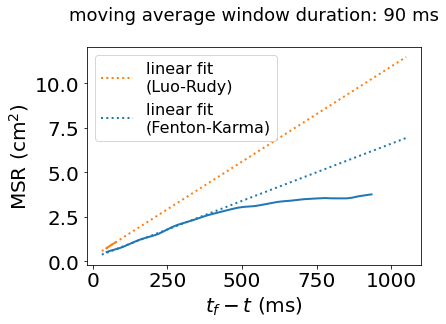

In [591]:
#plot linear law fit
plt.plot(t_LR,MSR_LR,lw=2,c='C1')#,label='Luo-Rudy')
plt.plot(t_FK,MSR_FK,lw=2,c='C0')#,label='Fenton-Karma')
plt.plot(xv,yhat_LR,":",lw=2,c='C1',label='linear fit\n(Luo-Rudy)')
plt.plot(xv,yhat_FK,":",lw=2,c='C0',label='linear fit\n(Fenton-Karma)')
#format
plt.legend(fontsize=16)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([.1,2])
# plt.ylim([.1,2.2])
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.title(f'moving average window duration: {tavg:.0f} ms\n',fontsize=18)
plt.show()

In [ ]:
#TODO: plot ^that but with the power law fit for first 8ms of the LR model


In [549]:
num_resampled_points_considered_lr=MSR_LR.shape[0]
num_resampled_points_considered_fk=MSR_FK.shape[0]
print(f"num_resampled_points_considered_lr={num_resampled_points_considered_lr}")
print(f"num_resampled_points_considered_fk={num_resampled_points_considered_fk}")

num_resampled_points_considered_lr=300
num_resampled_points_considered_fk=8876


In [515]:
#compute radial velocities for the moving average
R_FK=np.sqrt(MSR_FK)
dRdt_FK=np.array([x/y for x,y in zip(np.diff(R_FK),np.diff(t_FK))])*1e3
R_FK=0.5*(R_FK[1:]+R_FK[:-1])
R_LR=np.sqrt(MSR_LR)
dRdt_LR=np.array([x/y for x,y in zip(np.diff(R_LR),np.diff(t_LR))])*1e3
R_LR=0.5*(R_LR[1:]+R_LR[:-1])

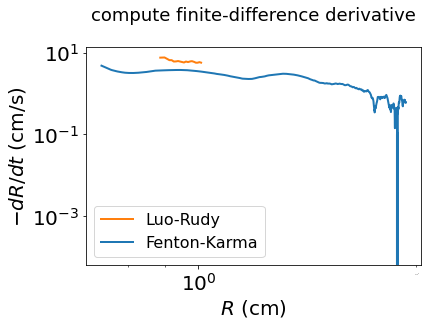

In [516]:
plt.plot(R_LR,dRdt_LR,lw=2,c='C1',label='Luo-Rudy')
plt.plot(R_FK,dRdt_FK,lw=2,c='C0',label='Fenton-Karma')

plt.legend(fontsize=16)
plt.xscale('log')
plt.yscale('log')
# plt.xlim([.1,2])
# plt.ylim([.1,2.2])
format_plot(ax=plt.gca(),xlabel=r'$R$ (cm)',ylabel=r'$-dR/dt$ (cm/s)')
plt.title(f'compute finite-difference derivative\n',fontsize=18)
# plt.title(f'large sample sizes\n(highlighted values)\n',fontsize=18)
# plt.title(f'(highlighted) values with the large sample sizes\n',fontsize=18)
plt.show()

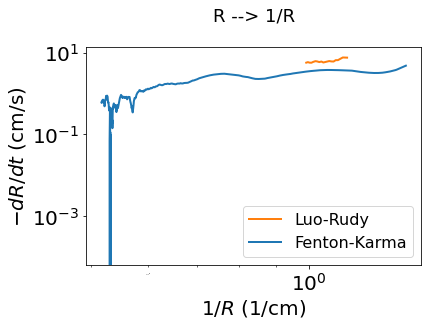

In [517]:
plt.plot(1/R_LR,dRdt_LR,lw=2,c='C1',label='Luo-Rudy')
plt.plot(1/R_FK,dRdt_FK,lw=2,c='C0',label='Fenton-Karma')

plt.legend(fontsize=16)
plt.xscale('log')
plt.yscale('log')
# plt.xlim([.1,2])
# plt.ylim([.1,2.2])
format_plot(ax=plt.gca(),xlabel=r'$1/R$ (1/cm)',ylabel=r'$-dR/dt$ (cm/s)')
plt.title(f'R --> 1/R\n',fontsize=18)
# plt.title(f'large sample sizes\n(highlighted values)\n',fontsize=18)
# plt.title(f'(highlighted) values with the large sample sizes\n',fontsize=18)
plt.show()

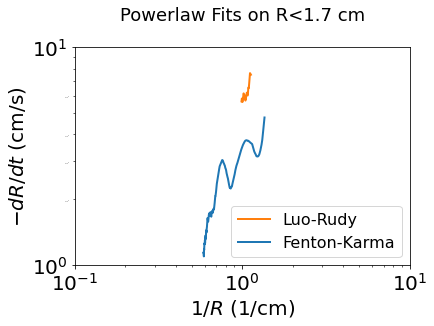

In [518]:
Rmax=1.7 #cm
boo_LR=R_LR<Rmax
boo_FK=R_FK<Rmax

#TODO: compute powerlaw fits

#TODO: plot powerlaw fits

#TODO: print powerlaw fits

plt.plot(1/R_LR[boo_LR],dRdt_LR[boo_LR],lw=2,c='C1',label='Luo-Rudy')
plt.plot(1/R_FK[boo_FK],dRdt_FK[boo_FK],lw=2,c='C0',label='Fenton-Karma')

plt.legend(fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim([.1,10])
plt.ylim([1,10])
format_plot(ax=plt.gca(),xlabel=r'$1/R$ (1/cm)',ylabel=r'$-dR/dt$ (cm/s)')
plt.title(f'Powerlaw Fits on R<{Rmax:.1f} cm\n',fontsize=18)
# plt.title(f'large sample sizes\n(highlighted values)\n',fontsize=18)
# plt.title(f'(highlighted) values with the large sample sizes\n',fontsize=18)
plt.show()

In [519]:
x=1/R_LR[boo_LR]
y=dRdt_LR[boo_LR]
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
print(f"B,Delta_B,m,Delta_m,Rsq={B,Delta_B,m,Delta_m,Rsq}")

#TODO: compute yhat

x=1/R_FK[boo_FK]
y=dRdt_FK[boo_FK]
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
print(f"B,Delta_B,m,Delta_m,Rsq={B,Delta_B,m,Delta_m,Rsq}")

#TODO: compute yhat


B,Delta_B,m,Delta_m,Rsq=(2.45990115099412, 0.21243675369746373, 1.971575292863537, 0.17170875849111653, 0.7199597470404638)
B,Delta_B,m,Delta_m,Rsq=(2.081674019367696, 0.03538948024150074, 1.3360512389573984, 0.02142401625879475, 0.7871052054926515)


when tavg=90ms
- LR model: apparent exponent is 1.97(10)
- FK model: apparent exponent is 1.25(3)

# computing/visualizing powerlaw exponents for the full models

t_start=3.475242386232975,t_end=40.09452477094064,num_tbins=19
considering all time bins with at least N=4236 samples
t_start=4.87544877720002,t_end=38.52789862900964,num_tbins=18
considering all time bins with at least N=94045 samples


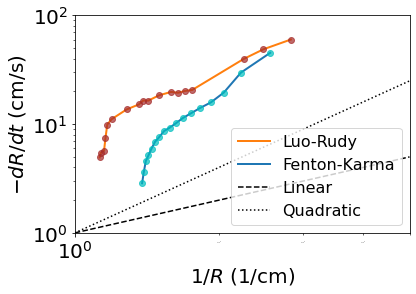

In [395]:
tol_max_sample_fraction=.005
df=df_lr
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_lr
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=df.loc[boo,'R'].values
dRdt_values=df.loc[boo,'dRdt'].values
#plot
plt.plot(1/df[boo]['R'].values,df[boo]['dRdt'].values,lw=2,c='C1',label='Luo-Rudy')
plt.plot(1/R_values,dRdt_values,'o',c='brown',lw=1,alpha=0.7)

df=df_fk.copy()
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_fk
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=df.loc[boo,'R'].values
dRdt_values=df.loc[boo,'dRdt'].values
#plot
plt.plot(1/df[boo]['R'].values,df[boo]['dRdt'].values,lw=2,c='C0',label='Fenton-Karma')
plt.plot(1/R_values,dRdt_values,'o',c='c',lw=1,alpha=0.7)

x=np.linspace(1,5,100)
plt.plot(x,x,'k--',label='Linear')
plt.plot(x,x**2,'k:',label='Quadratic')

plt.legend(fontsize=16,loc='lower right')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e0,5])
plt.ylim([1,100])
format_plot(ax=plt.gca(),xlabel=r'$1/R$ (1/cm)',ylabel=r'$-dR/dt$ (cm/s)')
plt.show()
#TODO: google 'how to change typing to insert linux keyboard'

# scratchwerk

In [ ]:

df=df_lr
tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_lr
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=np.sqrt(df.loc[boo,'MSR']).values
#plot
plt.plot(t_values,R_values,'o',c='brown',lw=1,alpha=0.7)
plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C1',label='Luo-Rudy')


df=df_fk.copy()
# tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_fk
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=np.sqrt(df.loc[boo,'MSR']).values
#plot
plt.plot(t_values,R_values,'co',lw=1,alpha=0.7)
plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C0',label='Fenton-Karma')


# #plot vertical lines for each
# yv=np.linspace(0,2)
# ax.plot(tstart_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tend_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tstart_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)
# ax.plot(tend_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)

plt.legend(fontsize=16)
plt.xscale('log')
plt.yscale('log')
# plt.xlim([.1,2])
plt.ylim([.1,2.2])
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.title(f'large sample sizes\n(highlighted values)\n',fontsize=18)
# plt.title(f'(highlighted) values with the large sample sizes\n',fontsize=18)
plt.show()
#DONE: extract MSR versus tdeath_avg for both models
#TODO: visualize MSR versus tdeath_avg for LR model too
#TODO: plot on log-log plot
#TODO: compute derivative by finite difference
#TODO: visualize (-)dRdt versus R. try the following:
# - linlin
# - loglog
# - loglin
# - linlog 
#TODO: google 'how to change typing to insert linux keyboard'

In [149]:
#TODO: compute dRdt_values
# dRdt_values=np.diff()
plt.subplots

<function matplotlib.pyplot.subplots(nrows=1, ncols=1, *, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)>

t_start=4.87544877720002,t_end=38.52789862900964,num_tbins=18
considering all time bins with at least N=94045 samples
t_start=3.475242386232975,t_end=40.09452477094064,num_tbins=19
considering all time bins with at least N=4236 samples


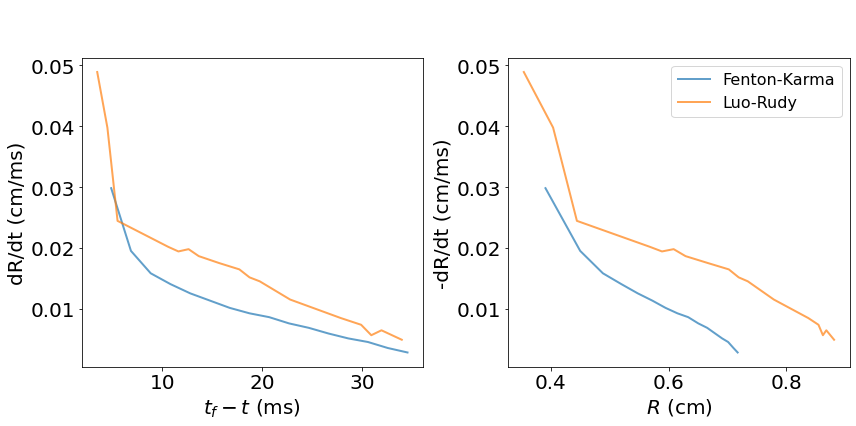

In [302]:
fig,axs=plt.subplots(ncols=2,figsize=(12,6))#,constrained=True)#

df=df_fk.copy()
# tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_fk
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=np.sqrt(df.loc[boo,'MSR']).values
#compute dRdt_values
dRdt_values=np.array([x/y for x,y in zip(np.diff(R_values),np.diff(t_values))])
# #plot
# axs[0].plot(t_values,R_values,'co',lw=1,alpha=0.7)
# # axs[1].plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C0',label='Fenton-Karma')
#plot
axs[0].plot(t_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C0',label='Fenton-Karma')
# plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C1',label='Luo-Rudy')
axs[1].plot(R_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C0',label='Fenton-Karma')

df=df_lr
tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_lr
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size:.0f}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=np.sqrt(df.loc[boo,'MSR']).values
#compute dRdt_values
dRdt_values=np.array([x/y for x,y in zip(np.diff(R_values),np.diff(t_values))])

#plot
axs[0].plot(t_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C1',label='Luo-Rudy')
# plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C1',label='Luo-Rudy')
axs[1].plot(R_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C1',label='Luo-Rudy')
# plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C1',label='Luo-Rudy')





# #plot vertical lines for each
# yv=np.linspace(0,2)
# ax.plot(tstart_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tend_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tstart_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)
# ax.plot(tend_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)

plt.legend(fontsize=16)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([.1,2])
# plt.ylim([.1,2.2])
format_plot(ax=axs[0],xlabel=r'$t_f-t$ (ms)',ylabel='dR/dt (cm/ms)')
format_plot(ax=axs[1],xlabel=r'$R$ (cm)',ylabel=r'-dR/dt (cm/ms)')
fig.suptitle(f'\n',fontsize=18)
plt.tight_layout()
plt.show()
#DONE: extract MSR versus tdeath_avg for both models
#TODO: visualize MSR versus tdeath_avg for LR model too
#TODO: plot on log-log plot
#TODO: compute derivative by finite difference
#TODO: visualize (-)dRdt versus R. try the following:
# - linlin
# - loglog
# - loglin
# - linlog 
#TODO: google 'how to change typing to insert linux keyboard'

In [301]:
# # tol_max_sample_fraction=.005
# #find start/end times of max samples
# frac=(1-tol_max_sample_fraction)*num_samples_max_fk
# boo=df['counts'].values>=frac
# t_start=df[boo]['tdeath_avg'].min()
# t_end=df[boo]['tdeath_avg'].max()
# print(f"t_start={t_start},t_end={t_end},num_tbins={boo[boo].size}")
# boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
# print(f"considering all time bins with at least N={frac:.0f} samples")
# #extract MSR versus tdeath_avg in this range
# t_values=df.loc[boo,'tdeath_avg'].values
# R_values=np.sqrt(df.loc[boo,'MSR']).values
# #compute dRdt_values
# dRdt_values=np.array([x/y for x,y in zip(np.diff(R_values),np.diff(t_values))])


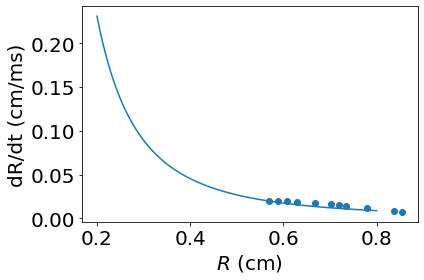

y=M*(x)**m
m=-2.343813+-0.558335; B=9.343216+-2.161926
M= 0.005313+-0.007446 Hz*cm^{2(m-1)}
RMSE=0.0027 Hz/cm^2
R^2=0.8827


In [240]:
tmin=10
tmax=30#18
boo=(t_values>tmin)&(t_values<tmax)
plt.scatter(x=R_values[boo],y=dRdt_values[boo[:-1]])
# comp ols
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x=R_values[boo],y=dRdt_values[boo[:-1]])
x=np.linspace(0.2,.8,100)
plt.plot(x,(B*x)**m)
format_plot(ax=plt.gca(),xlabel=r'$R$ (cm)',ylabel=r'dR/dt (cm/ms)')
fig.suptitle(f'\n',fontsize=18)
plt.tight_layout()
plt.show()
# print((m,Delta_m,b,Delta_b,p))
print_fit_power_law(x=R_values[boo],y=dRdt_values[boo[:-1]])

t_start=4.8754,t_end=38.5279,num_tbins=18
considering all time bins with at least N=94045 samples
powerlaw fit for FK:
m=-0.056106362712752364
Delta_m=0.0030298914008621246
b=0.043768976606120454
Delta_b=0.001882439022782828
Rsquared=0.9902277137114317
m=-0.056106362712752364
Delta_m=0.0030298914008621246
b=0.043768976606120454
Delta_b=0.001882439022782828
Rsquared=0.9902277137114317
t_start=3.4752,t_end=40.0945,num_tbins=19
considering all time bins with at least N=4236 samples
powerlaw fit for LR:
m=-0.03179451001660754
Delta_m=0.003433108659745866
b=0.038558792047172316
Delta_b=0.0021333716291154752
Rsquared=0.9821156740893497
^these consider ranges Rmin=0.4200 cm through Rmax=0.7200 cm


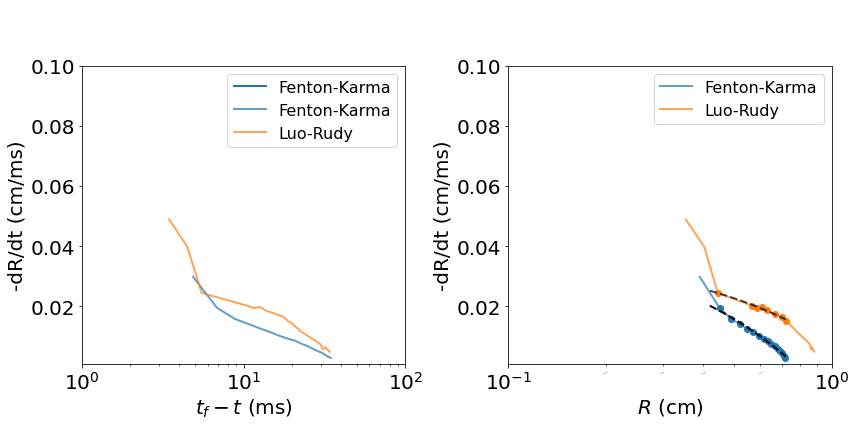

In [351]:
fig,axs=plt.subplots(ncols=2,figsize=(12,6))#,constrained=True)#
Rmin,Rmax=.42,.72
tmin=5#12
tmax=40#30#18
df=df_fk.copy()
# tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_fk
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start:.4f},t_end={t_end:.4f},num_tbins={boo[boo].size}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=np.sqrt(df.loc[boo,'MSR']).values
#compute dRdt_values
dRdt_values=np.array([x/y for x,y in zip(np.diff(R_values),np.diff(t_values))])
# dRdt_values-=np.min(dRdt_values)

# #plot
# axs[0].plot(t_values,R_values,'co',lw=1,alpha=0.7)
axs[0].plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C0',label='Fenton-Karma')
#plot
axs[0].plot(t_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C0',label='Fenton-Karma')
# plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C1',label='Luo-Rudy')
axs[1].plot(R_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C0',label='Fenton-Karma')

# # comp ols
# # boo=(t_values>tmin)&(t_values<tmax)
# Rmin=0.45
# Rmax=0.8#18
# print(f"Rmin={Rmin},Rmax={Rmax}")
# boo=(R_values>Rmin)&(R_values<Rmax)
print(f"powerlaw fit for FK:")
# # boo=(R_values>Rmin)&(R_values<Rmax)
# # boo=(t_values>tmin)&(t_values<t_end)
# boo=(t_values>tmin)&(t_values<t_end)
# x=np.linspace(Rmin,Rmax,100)
# # print_fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# # B,Delta_B,m,Delta_m,Rsq=fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# # axs[1].plot(x,(B*x)**m,'k:',lw=2,alpha=0.4)
# dict_fit=compute_95CI_ols(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])

boo=(R_values>=Rmin)&(R_values<=Rmax)
axs[1].scatter(x=R_values[boo],y=dRdt_values[boo[:-1]],c='C0')
dict_fit=compute_95CI_ols(x=R_values[boo],y=dRdt_values[boo[:-1]])
print_dict(dict_fit)
axs[1].plot(x,dict_fit['b']+dict_fit['m']*x,'k--',lw=2,alpha=0.7)


print_dict(dict_fit)
axs[1].plot(x,dict_fit['b']+dict_fit['m']*x,'k--',lw=2,alpha=0.7)


df=df_lr
tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_lr
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start:.4f},t_end={t_end:.4f},num_tbins={boo[boo].size}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=np.sqrt(df.loc[boo,'MSR']).values
#compute dRdt_values
dRdt_values=np.array([x/y for x,y in zip(np.diff(R_values),np.diff(t_values))])
# dRdt_values-=np.min(dRdt_values)

#plot
axs[0].plot(t_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C1',label='Luo-Rudy')
# plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C1',label='Luo-Rudy')
axs[1].plot(R_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C1',label='Luo-Rudy')
# plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C1',label='Luo-Rudy')

# comp ols
# tmin=8
# # tmax=30#18
# boo=(t_values>tmin)&(t_values<tmax)
# Rmin=0.45
# Rmax=0.8#18
# boo=(R_values>Rmin)&(R_values<Rmax)
# boo=(t_values>t_start)&(t_values<t_end)
print(f"powerlaw fit for LR:")
# print_fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# B,Delta_B,m,Delta_m,Rsq=fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# x=np.linspace(Rmin,Rmax,100)
# axs[1].plot(x,(B*x)**m,'k--',lw=3,alpha=0.9)
x=np.linspace(Rmin,Rmax,100)
# print_fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# B,Delta_B,m,Delta_m,Rsq=fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# axs[1].plot(x,(B*x)**m,'k:',lw=2,alpha=0.4)

# boo=(t_values>tmin)&(t_values<tmax)
# axs[1].scatter(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# dict_fit=compute_95CI_ols(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])

boo=(R_values>=Rmin)&(R_values<=Rmax)
axs[1].scatter(x=R_values[boo],y=dRdt_values[boo[:-1]],c='C1')
dict_fit=compute_95CI_ols(x=R_values[boo],y=dRdt_values[boo[:-1]])
print_dict(dict_fit)
axs[1].plot(x,dict_fit['b']+dict_fit['m']*x,'k--',lw=2,alpha=0.7)


# #plot vertical lines for each
# yv=np.linspace(0,2)
# ax.plot(tstart_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tend_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tstart_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)
# ax.plot(tend_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)

axs[0].legend(fontsize=16)
axs[1].legend(fontsize=16)
axs[0].set_xscale('log')
# axs[0].set_yscale('log')
axs[1].set_xscale('log')
# axs[1].set_yscale('log')

axs[0].set_xlim([1,100])
axs[0].set_ylim([1e-3,1e-1])
axs[1].set_xlim([1e-1,1e0])
axs[1].set_ylim([1e-3,1e-1])

format_plot(ax=axs[0],xlabel=r'$t_f-t$ (ms)',ylabel='-dR/dt (cm/ms)')
format_plot(ax=axs[1],xlabel=r'$R$ (cm)',ylabel=r'-dR/dt (cm/ms)')
fig.suptitle(f'\n',fontsize=18)
plt.tight_layout()
print(f"^these consider ranges Rmin={Rmin:.4f} cm through Rmax={Rmax:.4f} cm")
plt.show()
#TODO: google 'how to change typing to insert linux keyboard'


t_start=4.8754,t_end=38.5279,num_tbins=18
considering all time bins with at least N=94045 samples
powerlaw fit for FK:
m=0.018739577164028895
Delta_m=0.0014337536849943636
b=-0.02181506115187444
Delta_b=0.002399650251012197
Rsquared=0.980575854426615
t_start=3.4752,t_end=40.0945,num_tbins=19
considering all time bins with at least N=4236 samples
powerlaw fit for LR:
m=0.02136979664575065
Delta_m=0.0034954058953559322
b=-0.016632674775744316
Delta_b=0.005447897082345468
Rsquared=0.9111606637505855


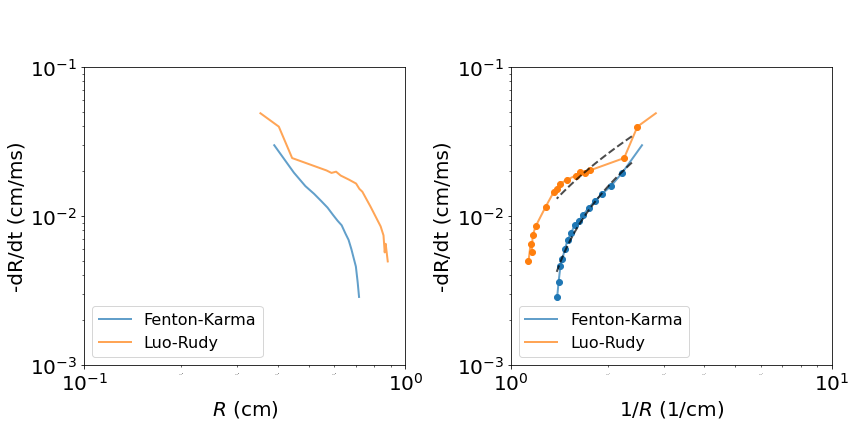

In [348]:
fig,axs=plt.subplots(ncols=2,figsize=(12,6))#,constrained=True)#
Rmin,Rmax=.42,.72
tmin=5#12
tmax=40#30#18
df=df_fk.copy()
# tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_fk
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start:.4f},t_end={t_end:.4f},num_tbins={boo[boo].size}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=np.sqrt(df.loc[boo,'MSR']).values
#compute dRdt_values
dRdt_values=np.array([x/y for x,y in zip(np.diff(R_values),np.diff(t_values))])
# dRdt_values-=np.min(dRdt_values)

# #plot
# axs[0].plot(t_values,R_values,'co',lw=1,alpha=0.7)
# # axs[1].plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C0',label='Fenton-Karma')
#plot
# axs[0].plot(t_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C0',label='Fenton-Karma')
# plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C1',label='Luo-Rudy')
axs[0].plot(R_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C0',label='Fenton-Karma')
axs[1].plot(1/R_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C0',label='Fenton-Karma')

# # comp ols
# # boo=(t_values>tmin)&(t_values<tmax)
# Rmin=0.45
# Rmax=0.8#18
# print(f"Rmin={Rmin},Rmax={Rmax}")
# boo=(R_values>Rmin)&(R_values<Rmax)
print(f"powerlaw fit for FK:")
# # boo=(R_values>Rmin)&(R_values<Rmax)
# # boo=(t_values>tmin)&(t_values<t_end)
# boo=(t_values>tmin)&(t_values<t_end)
# x=np.linspace(Rmin,Rmax,100)
# # print_fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# # B,Delta_B,m,Delta_m,Rsq=fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# # axs[1].plot(x,(B*x)**m,'k:',lw=2,alpha=0.4)
# dict_fit=compute_95CI_ols(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])


x=np.linspace(Rmin,Rmax,100)
x=1/x
# boo=(R_values>=Rmin)&(R_values<=Rmax)
boo=(t_values>t_start)&(t_values<t_end)
axs[1].scatter(x=1/R_values[boo][:-1],y=dRdt_values[boo[:-1]],c='C0')
dict_fit=compute_95CI_ols(x=1/R_values[boo][:-1],y=dRdt_values[boo[:-1]])
print_dict(dict_fit)
axs[1].plot(x,dict_fit['b']+dict_fit['m']*x,'k--',lw=2,alpha=0.7)


df=df_lr
tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_lr
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start:.4f},t_end={t_end:.4f},num_tbins={boo[boo].size}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=np.sqrt(df.loc[boo,'MSR']).values
#compute dRdt_values
dRdt_values=np.array([x/y for x,y in zip(np.diff(R_values),np.diff(t_values))])
# dRdt_values-=np.min(dRdt_values)

#plot
axs[0].plot(R_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C1',label='Luo-Rudy')
axs[1].plot(1/R_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C1',label='Luo-Rudy')

# comp ols
# tmin=8
# # tmax=30#18
# boo=(t_values>tmin)&(t_values<tmax)
# Rmin=0.45
# Rmax=0.8#18
# boo=(R_values>Rmin)&(R_values<Rmax)
# boo=(t_values>t_start)&(t_values<t_end)
print(f"powerlaw fit for LR:")
# print_fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# B,Delta_B,m,Delta_m,Rsq=fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# x=np.linspace(Rmin,Rmax,100)
# axs[1].plot(x,(B*x)**m,'k--',lw=3,alpha=0.9)
# print_fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# B,Delta_B,m,Delta_m,Rsq=fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# axs[1].plot(x,(B*x)**m,'k:',lw=2,alpha=0.4)

# boo=(t_values>tmin)&(t_values<tmax)
# axs[1].scatter(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# dict_fit=compute_95CI_ols(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])

x=np.linspace(Rmin,Rmax,100)
x=1/x
# boo=(R_values>=Rmin)&(R_values<=Rmax)
boo=(t_values>t_start)&(t_values<t_end)

axs[1].scatter(x=1/R_values[boo][:-1],y=dRdt_values[boo[:-1]],c='C1')
dict_fit=compute_95CI_ols(x=1/R_values[boo][:-1],y=dRdt_values[boo[:-1]])
print_dict(dict_fit)
axs[1].plot(x,dict_fit['b']+dict_fit['m']*x,'k--',lw=2,alpha=0.7)


# #plot vertical lines for each
# yv=np.linspace(0,2)
# ax.plot(tstart_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tend_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tstart_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)
# ax.plot(tend_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)

axs[0].legend(fontsize=16)
axs[1].legend(fontsize=16)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[0].set_xlim([1e-1,1e0])
axs[0].set_ylim([1e-3,1e-1])
axs[1].set_xlim([1e0,1e1])
axs[1].set_ylim([1e-3,1e-1])

format_plot(ax=axs[0],xlabel=r'$R$ (cm)',ylabel=r'-dR/dt (cm/ms)')
format_plot(ax=axs[1],xlabel=r'$1/R$ (1/cm)',ylabel=r'-dR/dt (cm/ms)')
fig.suptitle(f'\n',fontsize=18)
plt.tight_layout()
# print(f"^these consider ranges Rmin={Rmin:.4f} cm through Rmax={Rmax:.4f} cm")
plt.show()
#TODO: google 'how to change typing to insert linux keyboard'


t_start=4.8754,t_end=38.5279,num_tbins=18
considering all time bins with at least N=94045 samples
powerlaw fit for FK:
m=-0.056106362712752364
Delta_m=0.0030298914008621246
b=0.043768976606120454
Delta_b=0.001882439022782828
Rsquared=0.9902277137114317
m=-0.056106362712752364
Delta_m=0.0030298914008621246
b=0.043768976606120454
Delta_b=0.001882439022782828
Rsquared=0.9902277137114317
t_start=3.4752,t_end=40.0945,num_tbins=19
considering all time bins with at least N=4236 samples
powerlaw fit for LR:
m=-0.03179451001660754
Delta_m=0.003433108659745866
b=0.038558792047172316
Delta_b=0.0021333716291154752
Rsquared=0.9821156740893497
^these consider ranges Rmin=0.4200 cm through Rmax=0.7200 cm


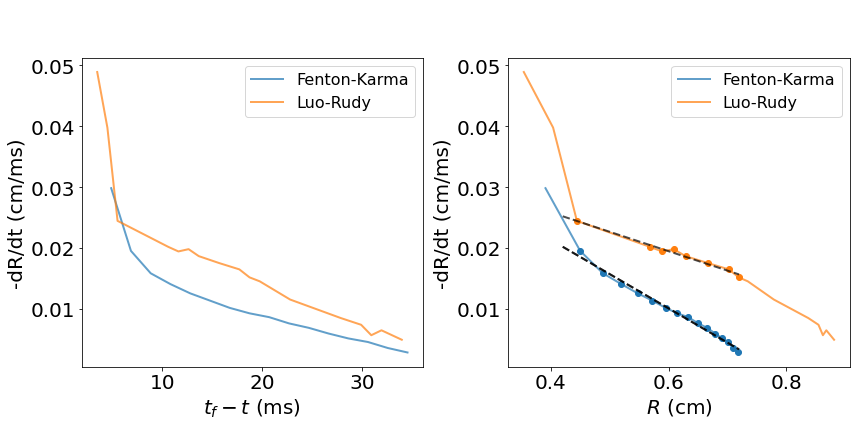

In [336]:
fig,axs=plt.subplots(ncols=2,figsize=(12,6))#,constrained=True)#
Rmin,Rmax=.42,.72
tmin=5#12
tmax=40#30#18
df=df_fk.copy()
# tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_fk
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start:.4f},t_end={t_end:.4f},num_tbins={boo[boo].size}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=np.sqrt(df.loc[boo,'MSR']).values
#compute dRdt_values
dRdt_values=np.array([x/y for x,y in zip(np.diff(R_values),np.diff(t_values))])
# #plot
# axs[0].plot(t_values,R_values,'co',lw=1,alpha=0.7)
# # axs[1].plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C0',label='Fenton-Karma')
#plot
axs[0].plot(t_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C0',label='Fenton-Karma')
# plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C1',label='Luo-Rudy')
axs[1].plot(R_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C0',label='Fenton-Karma')

# # comp ols
# # boo=(t_values>tmin)&(t_values<tmax)
# Rmin=0.45
# Rmax=0.8#18
# print(f"Rmin={Rmin},Rmax={Rmax}")
# boo=(R_values>Rmin)&(R_values<Rmax)
print(f"powerlaw fit for FK:")
# # boo=(R_values>Rmin)&(R_values<Rmax)
# # boo=(t_values>tmin)&(t_values<t_end)
# boo=(t_values>tmin)&(t_values<t_end)
# x=np.linspace(Rmin,Rmax,100)
# # print_fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# # B,Delta_B,m,Delta_m,Rsq=fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# # axs[1].plot(x,(B*x)**m,'k:',lw=2,alpha=0.4)
# dict_fit=compute_95CI_ols(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])

boo=(R_values>=Rmin)&(R_values<=Rmax)
axs[1].scatter(x=R_values[boo],y=dRdt_values[boo[:-1]],c='C0')
dict_fit=compute_95CI_ols(x=R_values[boo],y=dRdt_values[boo[:-1]])
print_dict(dict_fit)
axs[1].plot(x,dict_fit['b']+dict_fit['m']*x,'k--',lw=2,alpha=0.7)


print_dict(dict_fit)
axs[1].plot(x,dict_fit['b']+dict_fit['m']*x,'k--',lw=2,alpha=0.7)


df=df_lr
tol_max_sample_fraction=.005
#find start/end times of max samples
frac=(1-tol_max_sample_fraction)*num_samples_max_lr
boo=df['counts'].values>=frac
t_start=df[boo]['tdeath_avg'].min()
t_end=df[boo]['tdeath_avg'].max()
print(f"t_start={t_start:.4f},t_end={t_end:.4f},num_tbins={boo[boo].size}")
boo&=(df['tdeath_avg']>=t_start)&(df['tdeath_avg']<t_end)
print(f"considering all time bins with at least N={frac:.0f} samples")
#extract MSR versus tdeath_avg in this range
t_values=df.loc[boo,'tdeath_avg'].values
R_values=np.sqrt(df.loc[boo,'MSR']).values
#compute dRdt_values
dRdt_values=np.array([x/y for x,y in zip(np.diff(R_values),np.diff(t_values))])

#plot
axs[0].plot(t_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C1',label='Luo-Rudy')
# plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C1',label='Luo-Rudy')
axs[1].plot(R_values[:-1],dRdt_values,alpha=0.7,lw=2,c='C1',label='Luo-Rudy')
# plt.plot(df['tdeath_avg'].values,df['MSR'].values**0.5,lw=2,c='C1',label='Luo-Rudy')

# comp ols
# tmin=8
# # tmax=30#18
# boo=(t_values>tmin)&(t_values<tmax)
# Rmin=0.45
# Rmax=0.8#18
# boo=(R_values>Rmin)&(R_values<Rmax)
# boo=(t_values>t_start)&(t_values<t_end)
print(f"powerlaw fit for LR:")
# print_fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# B,Delta_B,m,Delta_m,Rsq=fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# x=np.linspace(Rmin,Rmax,100)
# axs[1].plot(x,(B*x)**m,'k--',lw=3,alpha=0.9)
x=np.linspace(Rmin,Rmax,100)
# print_fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# B,Delta_B,m,Delta_m,Rsq=fit_power_law(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# axs[1].plot(x,(B*x)**m,'k:',lw=2,alpha=0.4)

# boo=(t_values>tmin)&(t_values<tmax)
# axs[1].scatter(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])
# dict_fit=compute_95CI_ols(x=R_values[boo][:-1],y=dRdt_values[boo[:-1]])

boo=(R_values>=Rmin)&(R_values<=Rmax)
axs[1].scatter(x=R_values[boo],y=dRdt_values[boo[:-1]],c='C1')
dict_fit=compute_95CI_ols(x=R_values[boo],y=dRdt_values[boo[:-1]])
print_dict(dict_fit)
axs[1].plot(x,dict_fit['b']+dict_fit['m']*x,'k--',lw=2,alpha=0.7)


# #plot vertical lines for each
# yv=np.linspace(0,2)
# ax.plot(tstart_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tend_fk+0.*yv,yv,':',c='C0',alpha=0.7,lw=2)
# ax.plot(tstart_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)
# ax.plot(tend_lr+0.*yv,yv,'C1--',alpha=0.7,lw=2)

axs[0].legend(fontsize=16)
axs[1].legend(fontsize=16)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([.1,2])
# plt.ylim([.1,2.2])
format_plot(ax=axs[0],xlabel=r'$t_f-t$ (ms)',ylabel='-dR/dt (cm/ms)')
format_plot(ax=axs[1],xlabel=r'$R$ (cm)',ylabel=r'-dR/dt (cm/ms)')
fig.suptitle(f'\n',fontsize=18)
plt.tight_layout()
print(f"^these consider ranges Rmin={Rmin:.4f} cm through Rmax={Rmax:.4f} cm")
plt.show()
#TODO: google 'how to change typing to insert linux keyboard'


In [319]:
boo=(R_values>Rmin)&(R_values<Rmax)
boo
x=R_values[boo][:-1];y=dRdt_values[boo[:-1]]
x.shape,y.shape

((4,), (5,))

In [321]:
R_values.shape,dRdt_values.shape

((18,), (17,))

In [ ]:
x=R_values[boo],y=dRdt_values[boo[:-1]]

<function lib.measure.compute_slope.compute_95CI_ols(x, y)>

In [199]:
#TODO: plot the dotted lines for the powerlaw fit
#TODO: print parameters for each full model
#TODO: screenshot and put in pdf
#TODO: go to bed.

In [173]:

ddRdtdtdR_values=np.array([x/y for x,y in zip(np.diff(dRdt_values),np.diff(R_values))])
t_values

array([ 3.47524239,  4.4947906 ,  5.51373404, 10.59304833, 11.61129179,
       12.63188079, 13.65257042, 15.68759056, 17.72100973, 18.73979829,
       19.75804025, 22.8085642 , 27.88782774, 29.92345313, 30.94201651,
       31.96013619, 33.99622589, 35.0155349 ])

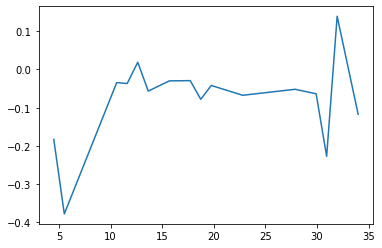

In [176]:
plt.plot(t_values[1:-1],ddRdtdtdR_values)